In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

#Sub-Halo Completeness

In this notebook, I examine evidence for sub-halo completeness by looking at the sub-halo fraction.

##Load Simulation Data

In [2]:
from halotools import sim_manager

#load halo catalogue
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol=0.001,
                                        version_name='custom', halo_finder='Rockstar')

print(halocat.halo_table.dtype.names)
print("number of (sub-)haloes: ", len(halocat.halo_table))

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')
number of (sub-)haloes:  6161686


In [3]:
#define cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology

##Sub-halo Fraction

In [4]:
def empirical_f_sub(halocat, mass_bins, mass_key ='halo_mpeak'):
    """
    """
    
    #identify types of haloes
    host = (halocat.halo_table['halo_upid'] == -1)
    sub = (halocat.halo_table['halo_upid'] != -1)

    x = halocat.halo_table[mass_key]
    sub_count = np.histogram(x[sub], bins=mass_bins)[0]
    host_count = np.histogram(x[host], bins=mass_bins)[0]

    f_sub = sub_count/(sub_count + host_count)
    err = np.sqrt(sub_count)/(host_count + sub_count) #poisson errors
    
    return f_sub, err


In [9]:
#define mass bins
min_mpeak = np.log10(halocat.particle_mass * 50.0) + 0.1
mass_bins = 10**np.arange(min_mpeak,14.5,0.2)
mass_bin_centers = (mass_bins[:-1]+mass_bins[1:])/2.0

#calculate sub-halo fraction
f_sub, err = empirical_f_sub(halocat, mass_bins)
mask = f_sub>0.0 #are there bins with no sub-haloes?

#define function form to fit to f_sub
def power_law_exp(x, f0=0.1, logx0=14, alpha=-0.1):
    """
    power law + exponential cut-off
    """
    x0 = 10.0**logx0
    return f0*((x/x0)**(alpha))*np.exp(-x/x0)

#fit function form to empirical result
from scipy.optimize import curve_fit
popt, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub[mask][7:], sigma=err[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('logx0 = {0} +- {1}'.format(popt[1],param_err[1]))
print('alpha = {0} +- {1}'.format(popt[2],param_err[2]))
f_sub_model = lambda x: power_law_exp(x, *popt)

f0 = 0.104589596387 +- 0.00646008650101
logx0 = 14.3957638725 +- 0.12809392961
alpha = -0.120144846177 +- 0.00529481030898


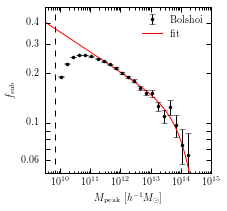

In [10]:
#plot subhalo fraction
msample = np.logspace(9,16,1000)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.3, 3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, hspace=0.0)
l1, = plt.plot(msample, f_sub_model(msample), '-', color='red')
#l2, = plt.plot(msample, f_sub_model_5(msample), '--', color='red')
#l3, = plt.plot(msample, f_sub_model_6(msample), ':', color='red')
p1 = plt.errorbar(mass_bin_centers, f_sub, yerr=err, fmt='o', color='black', ms=3)
#p1 = plt.errorbar(mass_bin_centers, f_sub_5, yerr=err_5, fmt='o', color='blue', ms=3)
#p1 = plt.errorbar(mass_bin_centers, f_sub_6, yerr=err_6, fmt='o', color='blue', ms=3)
plt.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**15.0])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$f_{\rm sub}$')
plt.legend((p1,l1),('Bolshoi','fit'), frameon = False, fontsize=10, loc='upper right', numpoints=1)
plt.show()

##Sub-halo Completeness

In [12]:
#define function form to fit to completeness
def c_sub_model(m, m0=10.0, gamma=1.2, ceil=1.0, floor=0.1):
    """
    model for subhalo completeness
    """
    m = np.atleast_1d(m)
    m0 = 10.0**m0
    c = -1.0*(m/m0)**(-1.0*10**gamma) + 1.0 - (1.0-ceil)
    c = ceil*((m/m0)**(-gamma) + 1.0)**(-1.0)
        
    return np.maximum(c, floor)

#calculate completenss given fit to f_sub
m1 = mass_bin_centers
c1 = f_sub/f_sub_model(mass_bin_centers)
err1 = err/f_sub_model(mass_bin_centers)

#get best fit parameters
from scipy.optimize import curve_fit
popt_c_11, pcov_c_11 = curve_fit(c_sub_model, m1, c1, sigma=err1,
                                 p0=[10.0,1.2])
param_c_err_11 = np.sqrt(pcov_c_11.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_11[0],param_c_err_11[0]))
print('gamma = {0} +- {1}'.format(popt_c_11[1],param_c_err_11[1]))
print(" ")
c_model = lambda x: c_sub_model(x, m0 = popt_c_11[0], gamma = popt_c_11[1])

m0 = 9.97963619845 +- 0.00279319785092
gamma = 1.26550335196 +- 0.0152803292623
 


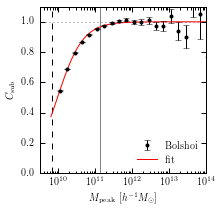

In [13]:
#plot sub-halo completeness
m_sample = np.logspace(9.8,15,100)
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

plt.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,1.1], '--', color='black')
plt.plot([1000*halocat.particle_mass,1000*halocat.particle_mass],[0.0,2.0],
         '-', color='grey')
plt.plot([10**9,10**16],[1.0,1.0], ':', color='grey')

#p0, = plt.plot(m_sample, subhalo_completeness_model(m_sample), '--', color='red')
p0, = plt.plot(m_sample, c_model(m_sample), '-', color='red')
p1 = plt.errorbar(m1,c1, yerr=err1, fmt='o', mec='none', color='black', ms=4)
plt.legend((p1,p0),(r'$\rm Bolshoi$', 'fit'),
           fontsize=10, frameon=False, loc='lower right',  numpoints=1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')
plt.ylabel(r'$C_{\rm sub}$')
plt.ylim([0,1.1])
plt.xlim([10**9.5,10**14])
plt.show()

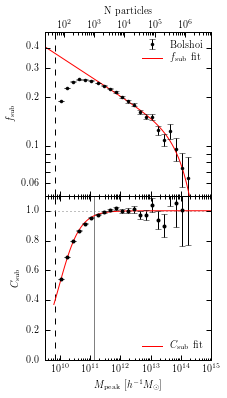

In [41]:
"""
combine f_sub and c_sub figures
"""

#plot subhalo fraction
msample = np.logspace(9,16,1000)
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(3.3, 5.7))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.9, hspace=0.0)

#top panel
ax=axes[0]
l1, = ax.plot(msample, f_sub_model(msample), '-', color='red')
p1 = ax.errorbar(mass_bin_centers, f_sub, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**15.0])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
#ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$f_{\rm sub}$')
ax.legend((p1,l1),('Bolshoi',r'$f_{\rm sub}~{\rm fit}$'), frameon = False, fontsize=10, loc='upper right', numpoints=1)

#upper axis
ax = ax.twiny()
n = msample/halocat.particle_mass
ax.plot(n, f_sub_model(msample)*0.0)
ax.set_xscale('log')
ax.set_xlabel('N particles', labelpad=8)
ax.set_yscale('log')
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_xlim([10**9.5/halocat.particle_mass,10**15.0/halocat.particle_mass])
ax.tick_params(axis='x', which='major', pad=1)

#lower panel
ax=axes[1]
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,1.1], '--', color='black')
ax.plot([1000*halocat.particle_mass,1000*halocat.particle_mass],[0.0,2.0],
         '-', color='grey')
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
p0, = ax.plot(m_sample, c_model(m_sample), '-', color='red')
p1 = ax.errorbar(m1,c1, yerr=err1, fmt='o', mec='none', color='black', ms=4)
ax.legend([p0],[r'$C_{\rm sub}~{\rm fit}$'],
           fontsize=10, frameon=False, loc='lower right',  numpoints=1)
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')
ax.set_ylabel(r'$C_{\rm sub}$')
ax.set_ylim([0,1.1])
ax.set_xlim([10**9.5,10**15])

plt.show()

filepath = './figures/'
filename = 'sub_fraction_and_completeness'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##Evolution of the sub-halo fraction

Here we look to see how f_sub and C_sub evolve.

###Load Simulations

In [42]:
#load other redshifts
simname = 'bolshoi_250'

halocat_redshifts = [0.0000,0.05335,0.10944,0.2463,0.5189,0.6713,1.0066,1.4854,2.0271,2.9628]

redshift = halocat_redshifts[0]
halocat_1 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[1]
halocat_2 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[2]
halocat_3 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[3]
halocat_4 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[4]
halocat_5 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[5]
halocat_6 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[6]
halocat_7 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[7]
halocat_8 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[8]
halocat_9 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')
redshift = halocat_redshifts[9]
halocat_10 = sim_manager.CachedHaloCatalog(simname = simname, redshift=redshift, dz_tol=0.001,
                                          version_name='custom', halo_finder='Rockstar')

In [60]:
def empirical_f_sub(halocat, mass_bins, mass_key ='halo_mpeak'):
    """
    """
    
    #identify types of haloes
    host = (halocat.halo_table['halo_upid'] == -1)
    sub = (halocat.halo_table['halo_upid'] != -1)

    x = halocat.halo_table[mass_key]
    sub_count = np.histogram(x[sub], bins=mass_bins)[0]
    host_count = np.histogram(x[host], bins=mass_bins)[0]

    f_sub = sub_count/(sub_count + host_count)
    err = np.sqrt(sub_count)/(host_count + sub_count) #poisson errors
    
    return f_sub, err

#define mass bins
min_mpeak = np.log10(halocat.particle_mass * 50.0) + 0.1
mass_bins = 10**np.arange(min_mpeak,14.5,0.2)
mass_bin_centers = (mass_bins[:-1]+mass_bins[1:])/2.0

#calculate and fit for each redshift
from scipy.optimize import curve_fit

#define function form to fit to f_sub
def power_law_exp(x, f0=0.1, logx0=14, alpha=-0.1):
    """
    power law + exponential cut-off
    """
    x0 = 10.0**logx0
    return f0*((x/x0)**(alpha))*np.exp(-x/x0)

#####
f_sub_1, err_1 = empirical_f_sub(halocat_1, mass_bins)
mask = f_sub_1>0.0
popt_1, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_1[mask][7:], sigma=err_1[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_1 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_1[0],param_err_1[0]))
print('logx0 = {0} +- {1}'.format(popt_1[1],param_err_1[1]))
print('alpha = {0} +- {1}'.format(popt_1[2],param_err_1[2]))
print(' ')
f_sub_model_1 = lambda x: power_law_exp(x, *popt_1)

#####
f_sub_2, err_2 = empirical_f_sub(halocat_2, mass_bins)
mask = f_sub_2>0.0
popt_2, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_2[mask][7:], sigma=err_2[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_2 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_2[0],param_err_2[0]))
print('logx0 = {0} +- {1}'.format(popt_2[1],param_err_2[1]))
print('alpha = {0} +- {1}'.format(popt_2[2],param_err_2[2]))
print(' ')
f_sub_model_2 = lambda x: power_law_exp(x, *popt_2)

#####
f_sub_3, err_3 = empirical_f_sub(halocat_3, mass_bins)
mask = f_sub_3>0.0
popt_3, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_3[mask][7:], sigma=err_3[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_3 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_3[0],param_err_3[0]))
print('logx0 = {0} +- {1}'.format(popt_3[1],param_err_3[1]))
print('alpha = {0} +- {1}'.format(popt_3[2],param_err_3[2]))
print(' ')
f_sub_model_3 = lambda x: power_law_exp(x, *popt_3)

#####
f_sub_4, err_4 = empirical_f_sub(halocat_4, mass_bins)
mask = f_sub_4>0.0
popt_4, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_4[mask][7:], sigma=err_4[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_4 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_4[0],param_err_4[0]))
print('logx0 = {0} +- {1}'.format(popt_4[1],param_err_4[1]))
print('alpha = {0} +- {1}'.format(popt_4[2],param_err_4[2]))
print(' ')
f_sub_model_4 = lambda x: power_law_exp(x, *popt_4)

#####
f_sub_5, err_5 = empirical_f_sub(halocat_5, mass_bins)
mask = f_sub_5>0.0
popt_5, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_5[mask][7:], sigma=err_5[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_5 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_5[0],param_err_5[0]))
print('logx0 = {0} +- {1}'.format(popt_5[1],param_err_5[1]))
print('alpha = {0} +- {1}'.format(popt_5[2],param_err_5[2]))
print(' ')
f_sub_model_5 = lambda x: power_law_exp(x, *popt_5)

#####
f_sub_6, err_6 = empirical_f_sub(halocat_6, mass_bins)
mask = (f_sub_6>0.0) & (mass_bin_centers<10**14)
popt_6, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_6[mask][7:], sigma=err_6[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_6 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_6[0],param_err_6[0]))
print('logx0 = {0} +- {1}'.format(popt_6[1],param_err_6[1]))
print('alpha = {0} +- {1}'.format(popt_6[2],param_err_6[2]))
print(' ')
f_sub_model_6 = lambda x: power_law_exp(x, *popt_6)

#####
f_sub_7, err_7 = empirical_f_sub(halocat_7, mass_bins)
mask = (f_sub_7>0.0) & (mass_bin_centers<10**14)
popt_7, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_7[mask][7:], sigma=err_7[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_7 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_7[0],param_err_7[0]))
print('logx0 = {0} +- {1}'.format(popt_7[1],param_err_7[1]))
print('alpha = {0} +- {1}'.format(popt_7[2],param_err_7[2]))
print(' ')
f_sub_model_7 = lambda x: power_law_exp(x, *popt_7)

#####
f_sub_8, err_8 = empirical_f_sub(halocat_8, mass_bins)
mask = (f_sub_8>0.0) & (mass_bin_centers<10**14)
popt_8, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_8[mask][7:], sigma=err_8[mask][7:],
                      p0=[0.133, 14, -0.1], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_8 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_8[0],param_err_8[0]))
print('logx0 = {0} +- {1}'.format(popt_8[1],param_err_8[1]))
print('alpha = {0} +- {1}'.format(popt_8[2],param_err_8[2]))
print(' ')
f_sub_model_8 = lambda x: power_law_exp(x, *popt_8)

#####
f_sub_9, err_9 = empirical_f_sub(halocat_9, mass_bins)
mask = (f_sub_9>0.0) & (mass_bin_centers<10**14)
popt_9, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_9[mask][7:], sigma=err_9[mask][7:],
                      p0=[0.06, 13, -0.24], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_9 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_9[0],param_err_9[0]))
print('logx0 = {0} +- {1}'.format(popt_9[1],param_err_9[1]))
print('alpha = {0} +- {1}'.format(popt_9[2],param_err_9[2]))
print(' ')
f_sub_model_9 = lambda x: power_law_exp(x, *popt_9)

#####
f_sub_10, err_10 = empirical_f_sub(halocat_10, mass_bins)
mask = (f_sub_10>0.0) & (mass_bin_centers<10**14)
popt_10, cov = curve_fit(power_law_exp, mass_bin_centers[mask][7:], f_sub_10[mask][7:], sigma=err_10[mask][7:],
                      p0=[0.03, 13, -0.34], bounds=([0.001,10.0,-1.0],[1.0,15.0,0.0]))
param_err_10 = np.sqrt(cov.diagonal())
print('f0 = {0} +- {1}'.format(popt_10[0],param_err_10[0]))
print('logx0 = {0} +- {1}'.format(popt_10[1],param_err_10[1]))
print('alpha = {0} +- {1}'.format(popt_10[2],param_err_10[2]))
print(' ')
f_sub_model_10 = lambda x: power_law_exp(x, *popt_10)

f0 = 0.104589596387 +- 0.00646008650101
logx0 = 14.3957638725 +- 0.12809392961
alpha = -0.120144846177 +- 0.00529481030898
 
f0 = 0.115356464997 +- 0.00742521392001
logx0 = 14.2810742174 +- 0.125126179235
alpha = -0.112888881127 +- 0.00645060932595
 
f0 = 0.123981492555 +- 0.00717350796992
logx0 = 14.1713292056 +- 0.104169743415
alpha = -0.106637539034 +- 0.00662413733964
 
f0 = 0.132448928501 +- 0.00487589654589
logx0 = 14.0151579054 +- 0.0588678375365
alpha = -0.104466243852 +- 0.00478223969077
 
f0 = 0.134387376461 +- 0.00447087481176
logx0 = 13.7544354765 +- 0.0445510100383
alpha = -0.109116361203 +- 0.00494657322509
 
f0 = 0.12909781079 +- 0.00553336600563
logx0 = 13.6355865414 +- 0.0529621781861
alpha = -0.118115184358 +- 0.00658592136623
 
f0 = 0.112350914015 +- 0.00565044810115
logx0 = 13.4567776977 +- 0.0538293259042
alpha = -0.144375591803 +- 0.00795004442386
 
f0 = 0.0825541930742 +- 0.00895519702529
logx0 = 13.3419531201 +- 0.104184919493
alpha = -0.195205866267 +- 0.015661

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:132: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:144: RuntimeWarning: invalid value encountered in greater



logx0 = 13.0871964563 +- 0.133780719183
alpha = -0.243079011567 +- 0.028308182709
 
f0 = 0.0264162278709 +- 0.00729353058267
logx0 = 13.0914128213 +- 0.201133734535
alpha = -0.342757247933 +- 0.0313565693855
 


In [56]:
#fit parameter dependence on redshift
redshifts = np.array(halocat_redshifts)

f0s = np.array([popt[0],popt_2[0],popt_3[0],popt_4[0],popt_5[0],
                popt_6[0],popt_7[0],popt_8[0],popt_9[0],popt_10[0]])

f0_errs = np.array([param_err[0], param_err_2[0], param_err_3[0], param_err_4[0],param_err_5[0],
                    param_err_6[0],param_err_7[0],param_err_8[0],param_err_9[0],param_err_10[0]])

x0s = np.array([popt[1],popt_2[1],popt_3[1],popt_4[1],popt_5[1],
                popt_6[1],popt_7[1],popt_8[1],popt_9[1],popt_10[1]])

x0_errs = np.array([param_err[1], param_err_2[1], param_err_3[1], param_err_4[1],param_err_5[1],
                    param_err_6[1], param_err_7[1], param_err_8[1], param_err_9[1], param_err_10[1]])

alphas = np.array([popt[2],popt_2[2],popt_3[2],popt_4[2],popt_5[2],
                   popt_6[2],popt_7[2],popt_8[2],popt_9[2],popt_10[2]])

alpha_errs = np.array([param_err[2], param_err_2[2], param_err_3[2], param_err_4[2],param_err_5[2],
                       param_err_6[2],param_err_7[2],param_err_8[2],param_err_9[2],param_err_10[2]])

#define function form of models for dependence on redshift
def f_model_a(x, f0=0.2, alpha=2.0, beta=4.5, x1=0.0, f1=0.0):
    x = x+1.0
    x1 = x1+1.0
    return f0*((x/x1)**alpha)/(1.0+(x/x1)**beta) + f1

def f_model_c(x, f0=12.5, x0=0.5, alpha=-1.4):
    x = x+1.0
    x0 = x0+1.0
    return f0 + (x/x0)**alpha

#fit models to parameters
popt_11, pcov_11 = curve_fit(f_model_a, redshifts, f0s, sigma=f0_errs,
                           p0=[0.12,2.0,4.0,0.5], bounds=([-np.inf,-np.inf,0.0,0.0],[np.inf,np.inf,10.0,1.0]))
param_err_11 = np.sqrt(pcov_11.diagonal())
print('f0 = {0} +- {1}'.format(popt_11[0],param_err_11[0]))
print('alpha = {0} +- {1}'.format(popt_11[1],param_err_11[1]))
print('beta = {0} +- {1}'.format(popt_11[2],param_err_11[2]))
print('x1 = {0} +- {1}'.format(popt_11[3],param_err_11[3]))
print(" ")
f0s_model = lambda x: f_model_a(x, *popt_11)

popt_22, pcov_22 = curve_fit(f_model_c, redshifts, x0s, sigma=x0_errs,
                           p0=[12.5,0.5,-1.4], bounds=([10.0,0.0,-3.0],[15.0,1.0,0.0]))
param_err_22 = np.sqrt(pcov_22.diagonal())
print('f0 = {0} +- {1}'.format(popt_22[0],param_err_22[0]))
print('x0 = {0} +- {1}'.format(popt_22[1],param_err_22[1]))
print('alpha = {0} +- {1}'.format(popt_22[2],param_err_22[2]))
print(" ")
x0s_model = lambda x: f_model_c(x, *popt_22)

popt_33, pcov_33 = curve_fit(f_model_a, redshifts, alphas, sigma=alpha_errs,
                           p0=[0.12,2.0,4.0,0.5,-0.225],
                           bounds=([-np.inf,-np.inf,0.0,0.0,-1.0],[np.inf,np.inf,10.0,1.0,0.0]))
param_err_33 = np.sqrt(pcov_33.diagonal())
print('f0 = {0} +- {1}'.format(popt_33[0],param_err_33[0]))
print('alpha = {0} +- {1}'.format(popt_33[1],param_err_33[1]))
print('beta = {0} +- {1}'.format(popt_33[2],param_err_33[2]))
print('x1 = {0} +- {1}'.format(popt_33[3],param_err_33[3]))
print('f1 = {0} +- {1}'.format(popt_33[4],param_err_33[4]))
print(" ")
alphas_model = lambda x: f_model_a(x, *popt_33)

f0 = 0.266927689806 +- 0.0104760272191
alpha = 1.58683396111 +- 0.339356180112
beta = 3.93517101924 +- 0.155599042451
x1 = 0.601325148739 +- 0.154997625145
 
f0 = 12.635273696 +- 0.14656341744
x0 = 0.679863923353 +- 0.23642584112
alpha = -1.07178756243 +- 0.146564097316
 
f0 = 1.7710120169 +- 1.68488501618
alpha = 0.603723740768 +- 0.135947600321
beta = 1.4314658139 +- 0.703675925752
x1 = 0.622522202692 +- 1.02901578216
f1 = -1.0 +- 0.784875647956
 


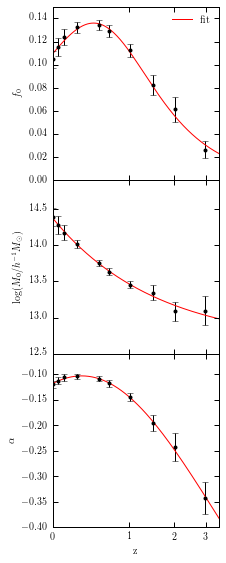

In [57]:
"""
plot parameter dependence on redshift and fits
"""
z_sample = np.logspace(-3,1,1000)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(3.3, 8.5))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.95, hspace=0.0)

#top panel
ax = axes[0]
l1, = ax.plot(1+z_sample, f0s_model(z_sample), color='red')
ax.errorbar(1+redshifts, f0s, yerr=f0_errs, fmt='o', mec='none', ms=4, color='black')
ax.set_xscale('log')
ax.set_xlim([1,4.5])
ax.set_ylim([0,0.15])
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['0','1','2','3'])
ax.set_ylabel(r'$f_0$')
ax.legend([l1],['fit'],frameon = False, fontsize=10, loc='upper right', numpoints=1)

#middle panel
ax = axes[1]
ax.plot(1+z_sample, x0s_model(z_sample), color='red')
ax.errorbar(1+redshifts, x0s, yerr=x0_errs, fmt='o', mec='none', ms=4, color='black')
ax.set_xscale('log')
ax.set_xlim([1,4.5])
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['0','1','2','3'])
ax.set_ylim([12.5,14.9])
ax.set_ylabel(r'$\log(M_0/h^{-1}M_{\odot})$')

#bottom panel
ax = axes[2]
ax.plot(1+z_sample, alphas_model(z_sample), color='red')
ax.errorbar(1+redshifts, alphas, yerr=alpha_errs, fmt='o', mec='none', ms=4, color='black')
ax.set_xscale('log')
ax.set_ylim([-0.4,-0.06])
ax.set_xlim([1,4.5])
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['0','1','2','3'])
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'z')

plt.show()

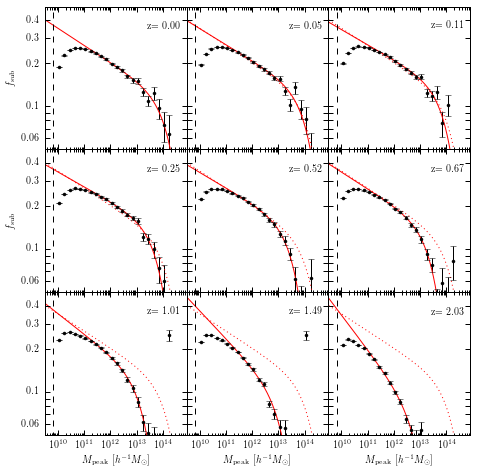

In [72]:
"""
plot evolution of the sub-halo fraction
"""

fig, axes = plt.subplots(nrows=3,ncols=3, sharex=True, sharey=True, figsize=(6.95, 7.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.0, hspace=0.0)

ax = axes[0,0]
l1, = ax.plot(msample, f_sub_model_1(msample), '-', color='red')
p1 = ax.errorbar(mass_bin_centers, f_sub_1, yerr=err_1, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[0]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**15.0])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_ylabel(r'$f_{\rm sub}$')

ax = axes[0,1]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_2(msample), '-', color='red')
p1 = ax.errorbar(mass_bin_centers, f_sub_2, yerr=err, fmt='o', color='black', ms=3)
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[1]))
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**15.0])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)

ax = axes[0,2]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_3(msample), '-', color='red')
p1 = ax.errorbar(mass_bin_centers, f_sub_3, yerr=err, fmt='o', color='black', ms=3)
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[2]))
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**15.0])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)

ax = axes[1,0]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_4(msample), '-', color='red')
p1 = ax.errorbar(mass_bin_centers, f_sub_4, yerr=err, fmt='o', color='black', ms=3)
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[3]))
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_ylabel(r'$f_{\rm sub}$')

ax = axes[1,1]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_5(msample), '-', color='red')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[4]))
p1 = ax.errorbar(mass_bin_centers, f_sub_5, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)

ax = axes[1,2]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_6(msample), '-', color='red')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[5]))
p1 = ax.errorbar(mass_bin_centers, f_sub_6, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)

ax = axes[2,0]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_7(msample), '-', color='red')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[6]))
p1 = ax.errorbar(mass_bin_centers, f_sub_7, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')

ax = axes[2,1]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_8(msample), '-', color='red')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[7]))
p1 = ax.errorbar(mass_bin_centers, f_sub_8, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')

ax = axes[2,2]
l1, = ax.plot(msample, f_sub_model_1(msample), ':', color='red')
l3, = ax.plot(msample, f_sub_model_9(msample), '-', color='red')
ax.text(10**13.4,0.35,'z=' + "{:10.2f}".format(halocat_redshifts[8]))
p1 = ax.errorbar(mass_bin_centers, f_sub_9, yerr=err, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0.05,0.5])
ax.set_yticks([0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1]='0.06'
labels[5]='0.1'
labels[6]='0.2'
labels[7]='0.3'
labels[8]='0.4'
ax.set_yticklabels(labels)
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')
plt.show()

In [61]:
#calculate sub-halo completeness

m1 = mass_bin_centers
c1 = f_sub/f_sub_model(mass_bin_centers)
err1 = err/f_sub_model(mass_bin_centers)

m2 = mass_bin_centers
c2 = f_sub_2/f_sub_model_2(mass_bin_centers)
err2 = err_2/f_sub_model_2(mass_bin_centers)

m3 = mass_bin_centers
c3 = f_sub_3/f_sub_model_3(mass_bin_centers)
err3 = err_3/f_sub_model_3(mass_bin_centers)

m4 = mass_bin_centers
c4 = f_sub_4/f_sub_model_4(mass_bin_centers)
err4 = err_4/f_sub_model_4(mass_bin_centers)

m5 = mass_bin_centers
c5 = f_sub_5/f_sub_model_5(mass_bin_centers)
err5 = err_5/f_sub_model_5(mass_bin_centers)

m6 = mass_bin_centers
c6 = f_sub_6/f_sub_model_6(mass_bin_centers)
err6 = err_6/f_sub_model_6(mass_bin_centers)

m7 = mass_bin_centers
c7 = f_sub_7/f_sub_model_7(mass_bin_centers)
err7 = err_7/f_sub_model_7(mass_bin_centers)

m8 = mass_bin_centers
c8 = f_sub_8/f_sub_model_8(mass_bin_centers)
err8 = err_8/f_sub_model_8(mass_bin_centers)

m9 = mass_bin_centers
c9 = f_sub_9/f_sub_model_9(mass_bin_centers)
err9 = err_9/f_sub_model_9(mass_bin_centers)

m10 = mass_bin_centers
c10 = f_sub_10/f_sub_model_10(mass_bin_centers)
err10 = err_10/f_sub_model_10(mass_bin_centers)

#get best fit parameters
from scipy.optimize import curve_fit

#define function form to fit to completeness
def c_sub_model(m, m0=10.0, gamma=1.2, ceil=1.0, floor=0.1):
    """
    model for subhalo completeness
    """
    m = np.atleast_1d(m)
    m0 = 10.0**m0
    c = -1.0*(m/m0)**(-1.0*10**gamma) + 1.0 - (1.0-ceil)
    c = ceil*((m/m0)**(-gamma) + 1.0)**(-1.0)
        
    return np.maximum(c, floor)

popt_c_11, pcov_c_11 = curve_fit(c_sub_model, m1,c1, sigma=err1,
                                 p0=[10.0,1.2])
param_c_err_11 = np.sqrt(pcov_c_11.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_11[0],param_c_err_11[0]))
print('gamma = {0} +- {1}'.format(popt_c_11[1],param_c_err_11[1]))
print(" ")
c_model_1 = lambda x: c_sub_model(x, m0 = popt_c_11[0], gamma = popt_c_11[1])

popt_c_12, pcov_c_12 = curve_fit(c_sub_model, m2,c2, sigma=err2,
                                 p0=[10.0,1.2])
param_c_err_12 = np.sqrt(pcov_c_12.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_12[0],param_c_err_12[0]))
print('gamma = {0} +- {1}'.format(popt_c_12[1],param_c_err_12[1]))
print(" ")
c_model_2 = lambda x: c_sub_model(x, m0 = popt_c_12[0], gamma = popt_c_12[1])

popt_c_13, pcov_c_13 = curve_fit(c_sub_model, m3, c3, sigma=err3,
                                 p0=[10.0,1.2])
param_c_err_13 = np.sqrt(pcov_c_13.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_13[0],param_c_err_13[0]))
print('gamma = {0} +- {1}'.format(popt_c_13[1],param_c_err_13[1]))
print(" ")
c_model_3 = lambda x: c_sub_model(x, m0 = popt_c_13[0], gamma = popt_c_13[1])

popt_c_14, pcov_c_14 = curve_fit(c_sub_model, m4,c4, sigma=err4,
                                 p0=[10.0,1.2])
param_c_err_14 = np.sqrt(pcov_c_14.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_14[0],param_c_err_14[0]))
print('gamma = {0} +- {1}'.format(popt_c_14[1],param_c_err_14[1]))
print(" ")
c_model_4 = lambda x: c_sub_model(x, m0 = popt_c_14[0], gamma = popt_c_14[1])

popt_c_15, pcov_c_15 = curve_fit(c_sub_model, m5,c5, sigma=err5,
                                 p0=[10.0,1.2])
param_c_err_15 = np.sqrt(pcov_c_15.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_15[0],param_c_err_15[0]))
print('gamma = {0} +- {1}'.format(popt_c_15[1],param_c_err_15[1]))
print(" ")
c_model_5 = lambda x: c_sub_model(x, m0 = popt_c_15[0], gamma = popt_c_15[1])

popt_c_16, pcov_c_16 = curve_fit(c_sub_model, m6, c6, sigma=err6,
                                 p0=[10.0,1.2])
param_c_err_16 = np.sqrt(pcov_c_16.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_16[0],param_c_err_16[0]))
print('gamma = {0} +- {1}'.format(popt_c_16[1],param_c_err_16[1]))
print(" ")
c_model_6 = lambda x: c_sub_model(x, m0 = popt_c_16[0], gamma = popt_c_16[1])

mask_7 = (m7 < 10**13.5)
popt_c_17, pcov_c_17 = curve_fit(c_sub_model, m7[mask_7], c7[mask_7], sigma=err7[mask_7],
                                 p0=[10.0,1.2])
param_c_err_17 = np.sqrt(pcov_c_17.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_17[0],param_c_err_17[0]))
print('gamma = {0} +- {1}'.format(popt_c_17[1],param_c_err_17[1]))
print(" ")
c_model_7 = lambda x: c_sub_model(x, m0 = popt_c_17[0], gamma = popt_c_17[1])

mask_8 = (m8 < 10**13.5)
popt_c_18, pcov_c_18 = curve_fit(c_sub_model, m8[mask_8], c8[mask_8], sigma=err8[mask_8],
                                 p0=[10.0,1.2])
param_c_err_18 = np.sqrt(pcov_c_18.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_18[0],param_c_err_18[0]))
print('gamma = {0} +- {1}'.format(popt_c_18[1],param_c_err_18[1]))
print(" ")
c_model_8 = lambda x: c_sub_model(x, m0 = popt_c_18[0], gamma = popt_c_18[1])

mask_9 = (m9 < 10**13.5)
popt_c_19, pcov_c_19 = curve_fit(c_sub_model, m9[mask_9],c9[mask_9], sigma=err9[mask_9],
                                 p0=[10.0,1.2], bounds=([9.0,0.0],[12.0,5.0]))
param_c_err_19 = np.sqrt(pcov_c_19.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_19[0],param_c_err_19[0]))
print('gamma = {0} +- {1}'.format(popt_c_19[1],param_c_err_19[1]))
print(" ")
c_model_9 = lambda x: c_sub_model(x, m0 = popt_c_19[0], gamma = popt_c_19[1])

mask_10 = (m10 < 10**13.0)
popt_c_110, pcov_c_110 = curve_fit(c_sub_model, m10[mask_10],c10[mask_10], sigma=err10[mask_10],
                                   p0=[10.0,1.2], bounds=([9.0,0],[12.0,5.0]))
param_c_err_110 = np.sqrt(pcov_c_110.diagonal())
print('m0 = {0} +- {1}'.format(popt_c_110[0],param_c_err_110[0]))
print('gamma = {0} +- {1}'.format(popt_c_110[1],param_c_err_110[1]))
print(" ")
c_model_10 = lambda x: c_sub_model(x, m0 = popt_c_110[0], gamma = popt_c_110[1])

m0 = 9.97963619845 +- 0.00279319785092
gamma = 1.26550335196 +- 0.0152803292623
 
m0 = 9.95225833174 +- 0.00297213049448
gamma = 1.29049718316 +- 0.0156710858882
 
m0 = 9.9280717497 +- 0.00306070911256
gamma = 1.3144440263 +- 0.0156265654506
 
m0 = 9.87758308914 +- 0.00438310635042
gamma = 1.23966925794 +- 0.0179940263763
 
m0 = 9.80504408936 +- 0.00699795364445
gamma = 1.20767850471 +- 0.0234833003003
 
m0 = 9.79234214218 +- 0.00737867135071
gamma = 1.21600874549 +- 0.0244328906259
 
m0 = 9.79335949473 +- 0.0130481279099
gamma = 1.19036055204 +- 0.0425673646353
 
m0 = 9.84863758033 +- 0.0132819514537
gamma = 1.12674391697 +- 0.0462853238384
 
m0 = 9.85582912275 +- 0.00953913012269
gamma = 1.29328339638 +- 0.0421944388685
 
m0 = 9.87978676602 +- 0.00642913517905
gamma = 1.38900696679 +- 0.0349360035461
 


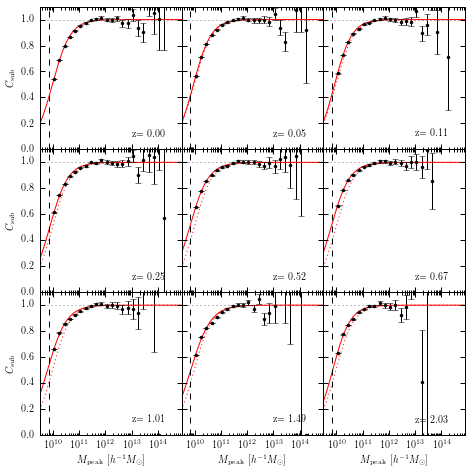

In [71]:
"""
plot evolution of the sub-halo completeness
"""

fig, axes = plt.subplots(nrows=3,ncols=3, sharex=True, sharey=True, figsize=(6.95, 7.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.0, hspace=0.0)

ax = axes[0,0]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), '-', color='red')
p1 = ax.errorbar(m1, c1, yerr=err1, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[0]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[0,1]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_2(msample), '-', color='red')
p1 = ax.errorbar(m2, c2, yerr=err2, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[1]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[0,2]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_3(msample), '-', color='red')
p1 = ax.errorbar(m3, c3, yerr=err3, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[2]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[1,0]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_4(msample), '-', color='red')
p1 = ax.errorbar(m4, c4, yerr=err4, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[3]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[1,1]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_5(msample), '-', color='red')
p1 = ax.errorbar(m5, c5, yerr=err5, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[4]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[1,2]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_6(msample), '-', color='red')
p1 = ax.errorbar(m6, c6, yerr=err6, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[5]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')

ax = axes[2,0]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_7(msample), '-', color='red')
p1 = ax.errorbar(m7, c7, yerr=err7, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[6]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
ax.set_ylabel(r'$C_{\rm sub}$')
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')

ax = axes[2,1]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_8(msample), '-', color='red')
p1 = ax.errorbar(m8, c8, yerr=err8, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[7]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')

ax = axes[2,2]
ax.plot([10**9,10**16],[1.0,1.0], ':', color='grey')
l1, = ax.plot(msample, c_model_1(msample), ':', color='red')
l1, = ax.plot(msample, c_model_9(msample), '-', color='red')
p1 = ax.errorbar(m9, c9, yerr=err9, fmt='o', color='black', ms=3)
ax.plot([50*halocat.particle_mass,50*halocat.particle_mass],[0.0,2.0], '--', color='black')
ax.text(10**13.0,0.1,'z=' + "{:10.2f}".format(halocat_redshifts[8]))
ax.set_xscale('log')
ax.set_xlim([10**9.5,10**14.9])
ax.set_ylim([0,1.1])
#ax.set_ylabel(r'$C_{\rm sub}$')
ax.set_xlabel(r'$M_{\rm peak}~[h^{-1}M_{\odot}]$')

plt.show()